In [1]:
import os, json, time
import gc
from IPython.display import display, Markdown 
from dotenv import load_dotenv
import matplotlib.pyplot as plt

In [ ]:
class CFG:
    OFFLINE = False #True # for Test offline environment
    USE_LLAMA3 = False # 
    USE_GEMMA2 = False # 
    USE_QWEN = False # 
    USE_DEEPSEEK = True # 

    TASK_GEN = True # for generative Text output task (suitable for RAG project)
    TEST_LLM = True
    USE_HUGGINGFACE = True # Pull model from Huggingface model hub
    USE_LMSTUIDO = False # for local LLM framework 
    USE_OLLAMA = False # for OLLAMA local LLM framework 
    USE_VLLM = False # for VLLM  LLM framework

    # mulitlingual LLM model 
    model1 = "meta-llama/Llama-3.2-3B-Instruct"  # llama3.2  3B-Instruct

    model2 =  "google/gemma-2-2b-it" # gemma 2 9B (mulitlingual)
    model3 = "Qwen/Qwen2.5-3B-Instruct" # Qwen 3B (mulitlingual)
    model4 = 'Qwen/Qwen2.5-7B-Instruct' # Qwen 7B (mulitlingual)
    model5 = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B" # DeepSeek Distill 1.5B (mulitlingual)
    model6 = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B" # DeepSeek Distill 7B (mulitlingual)
    
    # for VLM model
    vlmModel1 = "Qwen/Qwen2.5-VL-3B-Instruct"
    vlmModel2 = "Qwen/Qwen2.5-VL-7B-Instruct"


    # Mult Embedding model
    embedModel1 = 'intfloat/multilingual-e5-small' # for embedding model support chinese
    embedModel2 = "intfloat/multilingual-e5-large-instruct"
    embedModel3 = "Alibaba-NLP/gte-Qwen2-1.5B-instruct" # for embedding model support chinese
    embedModel4 = "Alibaba-NLP/gte-multilingual-base" # for embedding model support chinese
    embedModel5 = "BAAI/bge-m3" # for multilingual embedding model
    embedModel6 = "jinaai/jina-embeddings-v3"
    


    FEW_SHOT_TEST= False#True
    USE_RAG = True#False#False #True#True , in this project, prefer use fine tuning for p
    USE_WANDB = True#True # for  LLM evalution and debug , track fine tuning performance

    USE_DEEPEVAL = True#False # for LLM evalution   
    USE_TRAIN =  False #True #False#True Much be use GPU for Training 
    
    # For VectorDB selection
    USE_FAISS = False#True # For RAG VectorDB
    USE_CHROMA = False #True #False # for RAG VectorDF
    USE_PINECONE = True#False #True # for RAG VectorDF
    USE_WEAVIATE = False#True #False # for RAG VectorDF
    USE_MILVUS = False#True              # for RAG VectorDF

    # for LLM fine tuning
    maxTrainData = 200#3500#5000 #10000#5000 #10000
    maxEvalData = 20#100 # 20 

    
    maxToken=  512#768#512#768 # 512 for test only

In [3]:
import numpy as np
import pandas as pd
import transformers
import torch
from transformers import (AutoTokenizer, 
                          BitsAndBytesConfig,
                         AutoModelForCausalLM,
                         TrainingArguments)

from langchain_community.document_loaders import (TextLoader,
                                                  PyMuPDFLoader,
                                                  PyPDFDirectoryLoader,
                                                  PyPDFLoader)

# from langchain.document_loaders import PyPDFDirectoryLoader # old version of document loader

from langchain.prompts.prompt import  PromptTemplate

from langchain_community.vectorstores import FAISS #, Chroma,  Pinecone # old version of VectorStore



from langchain_text_splitters import (RecursiveCharacterTextSplitter,
                                      CharacterTextSplitter ,
                                       SentenceTransformersTokenTextSplitter)   


from langchain.embeddings import HuggingFaceEmbeddings # huggingfaceEmbedding deprecated , please use sentencetransformers 
from datasets import Dataset, DatasetDict, load_dataset


import evaluate
import trulens

2024-09-20 00:42:37.037231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
def clearMemory():
    for _ in range(5):
        torch.cuda.empty_cache()
        gc.collect()
        time.sleep(0.3)

### Get HuggingFace Hub Access for download model

In [6]:
load_dotenv()
huggingfaceToken = os.getenv("HuggingFace") #get huggeface token from .env file

In [7]:
if CFG.USE_WANDB:
    # train report to  W&B tool
    import wandb
    reportTo= "wandb"
    my_secret = os.getenv("wandb_api_key") 
    wandb.login(key=my_secret) # login 
else: 
    reportTo = "none"# None

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnsonhk88. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/johnsonhk88/.netrc


# Extract PDF File Contents

##### Use Simple pypdf extract simple pdf text data. But can't extract complex layout and extract position picture information from pdf, for test propose
##### We start use different AI model extract complex data

## Design AI model for Table detection, Image detection model, and Text detection model

## Load PDF File

In [8]:
## Define Test 
pdfFilePath1 = "../test-document/Attention .pdf"
pdfFilePath2 = "../test-document/yolo.pdf"
pdfDir = "../test-document"

In [9]:
# from  PyPDF2 import PdfReader
from pypdf import PdfReader
from langchain_community.document_loaders import PyMuPDFLoader #langchain pyMuPDF loader not perfect extract different f


from pdf2image import convert_from_path #for pdf to image convert
import cv2
import pymupdf
from PIL import Image

import pytesseract

## Test pymupdf library different formats extraction

In [10]:
loadPDF1 = pymupdf.open(pdfFilePath1)

In [11]:
clearMemory()

In [12]:
def extractTextFromPage(page):
    '''get text by pymupdf
    '''
    text = page.get_text()
    return text

In [13]:
def extractTableFromPage(page):
    tabs = page.find_tables()
    print(f"{len(tabs.tables)} found on {page}") # display number of found tables
    for i, tab in enumerate(tabs.tables):
        print(f"Table {i+1} : {tab.extract()}")
    return tabs

In [14]:
def extractImageFromPage(page):
    image_list = page.get_images()
    imginfo = page.get_image_info()
    print(imginfo)
    print(image_list)
    return image_list

In [15]:
for page in loadPDF1:
    # print(page)
    result = extractTextFromPage(page)
    # result = extractTableFromPage(page) #test extract table
    # result = extractImageFromPage(page) #test extract image
    print(type(result))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [16]:
page9 = loadPDF1[8]

In [17]:
page9

page 8 of ../test-document/Attention .pdf

In [18]:
# extract Table 
for page in loadPDF1:
    tabs = page.find_tables()
    if tabs.tables:
        print(tabs[0].extract())
        # print(tabs[0].extract())

[['', 'train\nN d d h d d P ϵ\nmodel ff k v drop ls steps', 'PPL BLEU params\n(dev) (dev) 106\n×'], ['base', '6 512 2048 8 64 64 0.1 0.1 100K', '4.92 25.8 65'], ['(A)', '1 512 512\n4 128 128\n16 32 32\n32 16 16', '5.29 24.9\n5.00 25.5\n4.91 25.8\n5.01 25.4'], ['(B)', '16\n32', '5.16 25.1 58\n5.01 25.4 60'], ['(C)', '2\n4\n8\n256 32 32\n1024 128 128\n1024\n4096', '6.11 23.7 36\n5.19 25.3 50\n4.88 25.5 80\n5.75 24.5 28\n4.66 26.0 168\n5.12 25.4 53\n4.75 26.2 90'], ['(D)', '0.0\n0.2\n0.0\n0.2', '5.77 24.6\n4.95 25.5\n4.67 25.3\n5.47 25.7'], ['(E)', 'positional embedding instead of sinusoids', '4.92 25.7'], ['big', '6 1024 4096 16 0.3 300K', '4.33 26.4 213']]
[['Parser', 'Training', 'WSJ 23 F1'], ['Vinyals & Kaiser el al. (2014) [37]\nPetrov et al. (2006) [29]\nZhu et al. (2013) [40]\nDyer et al. (2016) [8]', 'WSJ only, discriminative\nWSJ only, discriminative\nWSJ only, discriminative\nWSJ only, discriminative', '88.3\n90.4\n90.4\n91.7'], ['Transformer (4 layers)', 'WSJ only, discriminati

## Test OCR base PDF file extraction

In [19]:
# covert pdf to image
imgPdf =convert_from_path(pdfFilePath1)

In [20]:
len(imgPdf)

15

In [21]:
imgPdf

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>]

In [22]:
# Perform OCR on an image
page = imgPdf[2] # get page 3

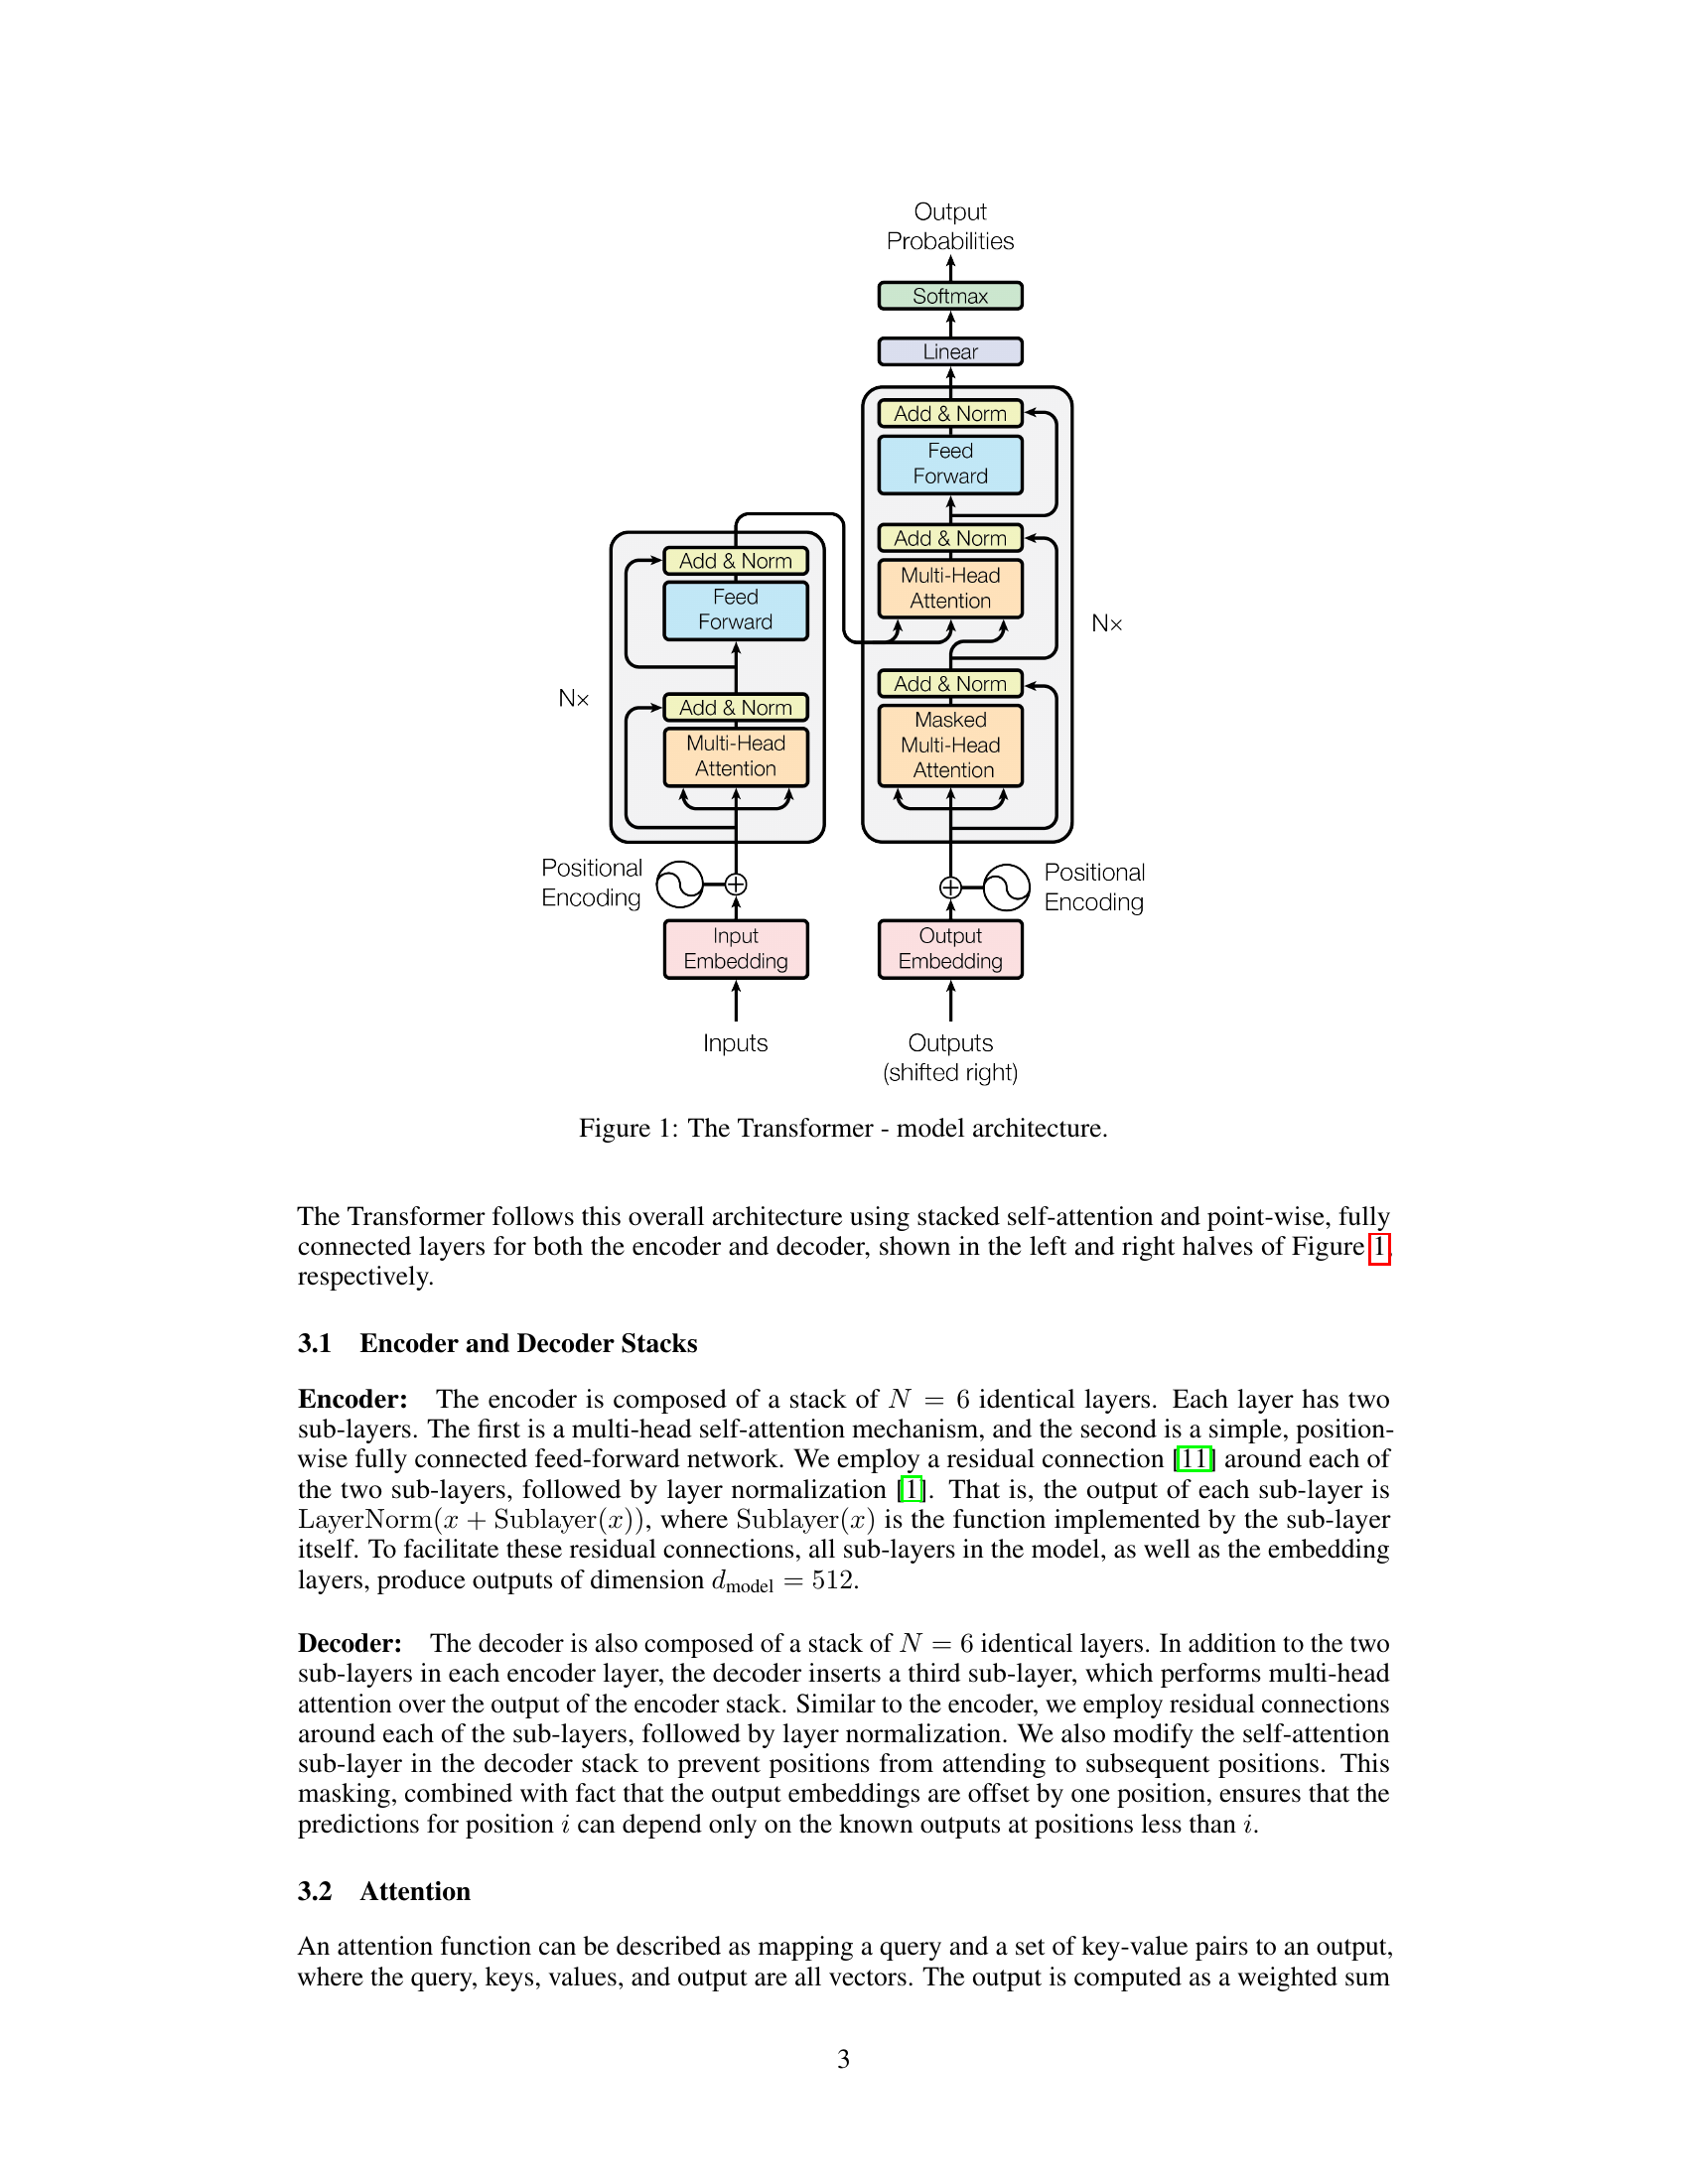

In [23]:
page

## Extract Text from PDF by OCR extraction

In [24]:
for page in imgPdf:
    text = pytesseract.image_to_string(page)
    print(text)

Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.

 

Attention Is All You Need

Ashish Vaswani* Noam Shazeer* Niki Parmar* Jakob Uszkoreit*
Google Brain Google Brain Google Research Google Research
avaswani@google.com noam@google.com nikip@google.com usz@google.com

Llion Jones* Aidan N. Gomez* ¢ Lukasz Kaiser*
Google Research University of Toronto Google Brain
llion@google.com aidan@cs.toronto.edu lukaszkaiser@google.com

Illia Polosukhin* +
illia.polosukhin@gmail.com

Abstract

The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
enti

In [25]:
text = pytesseract.image_to_string(page)
print(text)

 

   

<ped> <ped>

<SOS>\ <SO4>

uoluido = uoluido
Aw Aw

yeum
S|
sin

 

ysn[— i} -ysn{
_—8q

      

Pinoys“ pinoys
uoieadde * uojeodde
Ss}! S$}!

| ya |
ngs inq
pooped pooped
aq aq
Janou™ JO@ABU
HIM “TIM
me) me)
aul “OU

 

 

<ped> <ped>
so ————_<S0
UO|UIdO uoluldo
Aw Aw
ul ul
Bulssiw Bulssiw
ae ale
aM am
yeum yeum
s| s|
sty} # sly
-— -
a
3q 3q
Pinoys « pinoys

uoyjeoijdde ee
Ss}! Ss}!
inq ee
popod oo ated
3q 3q
JOABU JOABU
IW IW

rn
aul aul

Figure 5: Many of the attention heads exhibit behaviour that seems related to the structure of the

sentence. We give two such examples above, from two different heads from the encoder self-attention

at layer 5 of 6. The heads clearly learned to perform different tasks.

15



dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


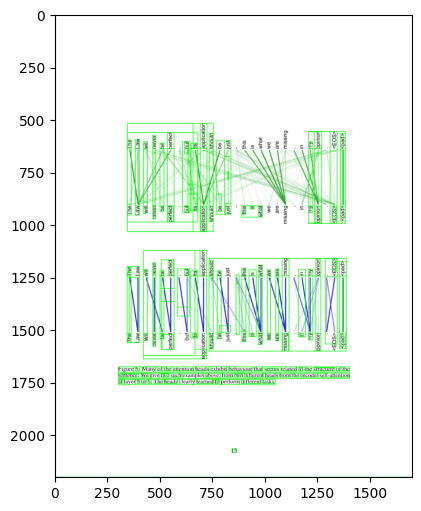

In [26]:
# extract page text with coordiate 
def extractPageImgTextWithCoord(pageImg):
    data = pytesseract.image_to_data(pageImg, output_type="dict")
    print(data.keys())
    numBox = len(data['level'])
    cv2img =cv2.cvtColor(np.array(pageImg), cv2.COLOR_RGB2BGR)
    # draw bounding box 
    for i in range(numBox):
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        cv2.rectangle(cv2img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # cv2.imshow("Image", cv2img) # show image with bounding box in window
    # # cv2.imshow("test", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2img)
    plt.show()
    return data


extractData = extractPageImgTextWithCoord(page)


In [27]:
type(page)

PIL.PpmImagePlugin.PpmImageFile

In [28]:
type(page)

PIL.PpmImagePlugin.PpmImageFile

In [29]:
# cv2.imshow("page", page)

In [30]:
# text = pytesseract.image_to_string(page)

In [31]:
# reader1 =PdfReader(pdfFilePath1)
# type(reader1)

In [32]:
# numPage = len(reader1.pages)

In [33]:
# reader1

In [34]:
# currentPage=reader1.pages[0]

In [35]:
# print(currentPage.extract_text())

In [36]:
def getPDFText(pdfDoc):
    '''
    get pdf text from pdf docs
    '''
    text="" 
    pdf_reader= PdfReader(pdfDoc) #read pdf file
    for page in pdf_reader.pages: # loop through pdf pages 
            text+= page.extract_text() # extract text from page and add to text variable
    return  text # return text variable

#### Use PyPDFDirectoryLoader from Langchain load PDF files from DirectoryLoader
<https://python.langchain.com/v0.2/docs/how_to/document_loader_pdf/#using-pypdf>

In [37]:
def getPDFDocs(directory):
    '''
    use PyPDFDirectoryLoader to extract pdf document from directory
    '''
    loader = PyPDFDirectoryLoader(directory) 
    docs = loader.load()
    return docs #text # return text variable

In [38]:
# rawTxt1 =getPDFText(pdfFilePath1)

In [39]:
# rawTxt2 = getPDFText(pdfFilePath2)
# type(rawTxt2)

In [40]:
docs =getPDFDocs(pdfDir)
docs

[Document(metadata={'source': '../test-document/yolo.pdf', 'page': 0}, page_content='Real-Time Flying Object Detection with YOLOv8\nDillon Reis*, Jordan Kupec, Jacqueline Hong, Ahmad Daoudi\nGeorgia Institute of Technology\ndreis7@gatech.edu *, jkupec3@gatech.edu, jhong356@gatech.edu, adaoudi3@gatech.edu\nAbstract\nThis paper presents a generalized model for real-time\ndetection of ﬂying objects that can be used for transfer\nlearning and further research, as well as a reﬁned model\nthat is ready for implementation. We achieve this by train-\ning our ﬁrst (generalized) model on a data set containing\n40 different classes of ﬂying objects, forcing the model to\nextract abstract feature representations. We then perform\ntransfer learning with these learned parameters on a data\nset more representative of “real world” environments (i.e.\nhigher frequency of occlusion, small spatial sizes, rotations,\netc.) to generate our reﬁned model. Object detection of ﬂy-\ning objects remains challeng

In [41]:
len(docs)

25

In [42]:
docs[0].metadata

{'source': '../test-document/yolo.pdf', 'page': 0}

# Document Data Analysis

## level 1 : Layout Analysis, extract/analysis document component


In [43]:
from ultralytics import YOLO


In [46]:

# Load a model
yoloModel = YOLO("yolov8n.pt")  # load an official model
# model = YOLO("path/to/best.pt")  # load a custom model

# Validate the model
# metrics = yoloModel.val()  # no arguments needed, dataset and settings remembered
# metrics.box.map  # map50-95
# metrics.box.map50  # map50
# metrics.box.map75  # map75
# metrics.box.maps  # a list contains map50-95 of each category

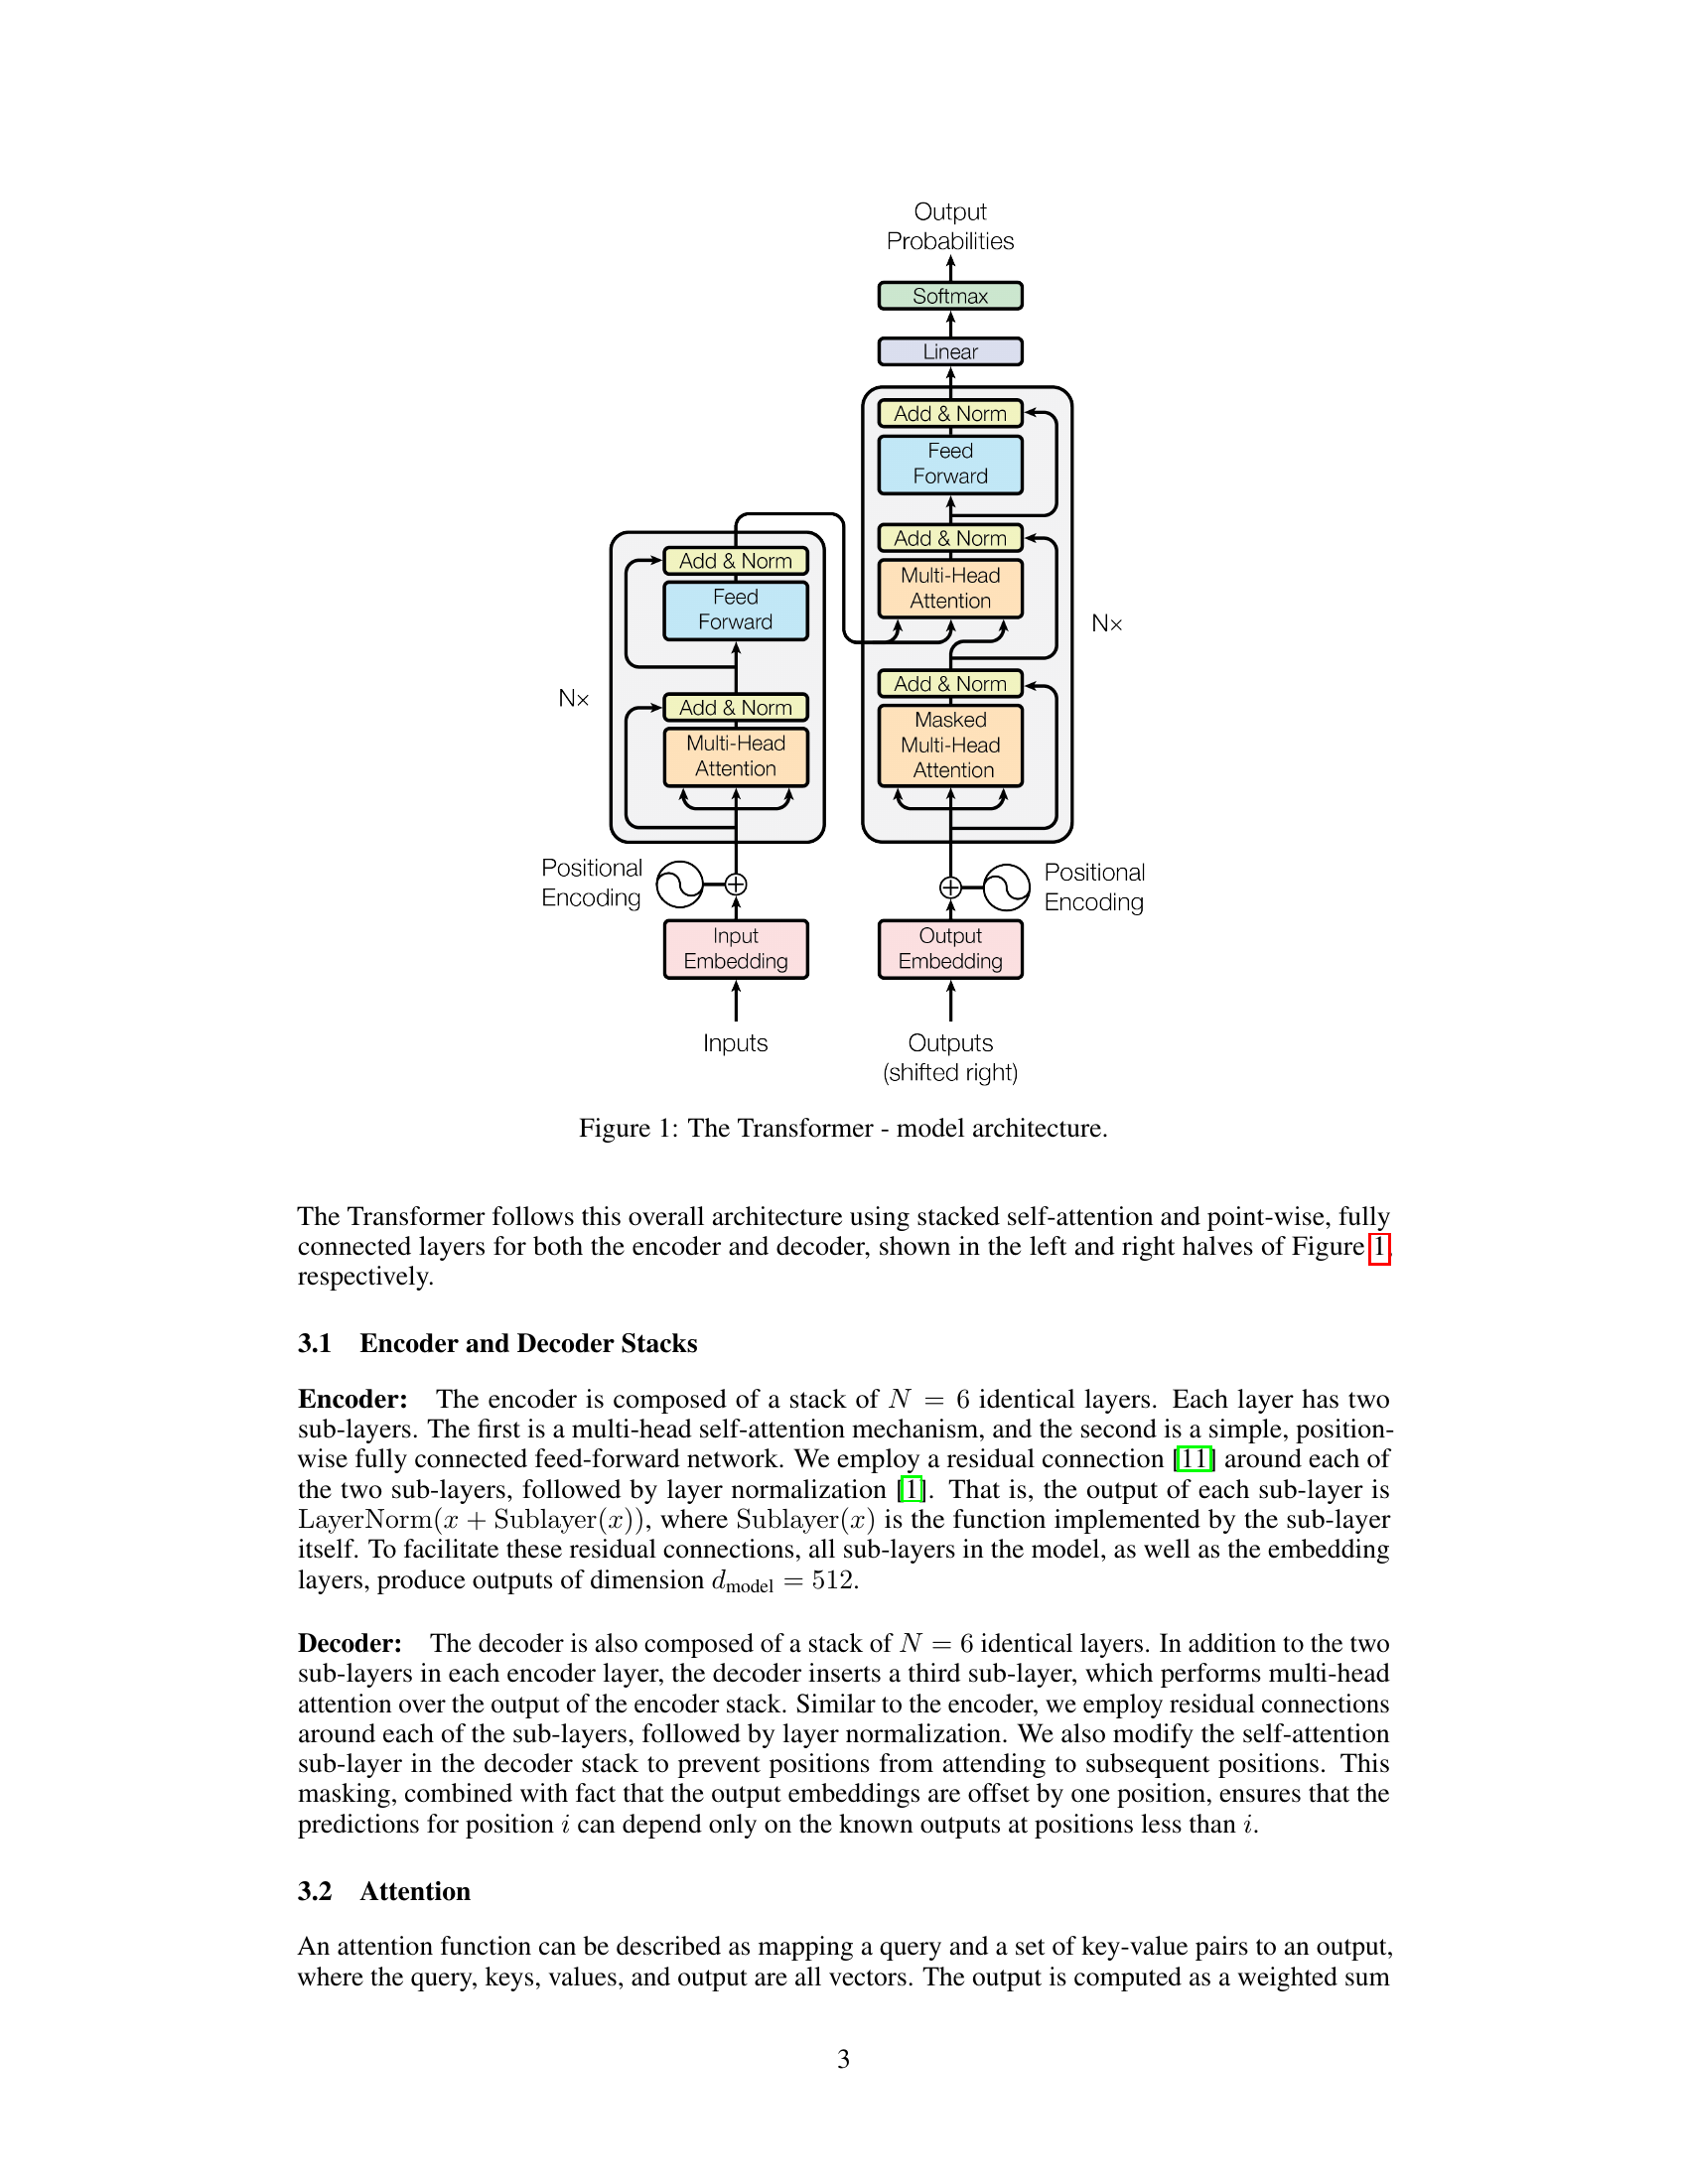

In [51]:
page3 = imgPdf[2]
page3 

In [52]:
result = yoloModel(page3)


0: 640x512 (no detections), 5.5ms
Speed: 11.5ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)


In [53]:
result

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

### level2 each component AI model extract data

# Level 3 Analysis task

## LLM Model Initialization

In [42]:
# Quantized Config for GPU support only
bnb_config = BitsAndBytesConfig(
        load_in_4bit = True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True # Activate nested quantization for 4-bit base models (double quantization)

)


In [43]:
# tokenizer = AutoTokenizer.from_pretrained(CFG.model2, token=huggingfaceToken)

In [ ]:
if CFG.USE_LMSTUIDO:
    # Point to the local server
    from langchain.llms import OpenAI
    import openai
    llmModel = "LMStudio"
    model = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

else: # load model from huggingface
    if device.type == "cuda": # use 7b/8b/9b model gain performance
        if CFG.USE_LLAMA3:
            modelSel = CFG.model1
            llmModel = "llama3_8b"
        
        elif CFG.USE_GEMMA2:
            modelSel = CFG.model4
            llmModel = "gemma2_9b"
        else:
            modelSel = CFG.model2
            llmModel = 'gemma_2b'
        
        if CFG.TASK_GEN:
            model = AutoModelForCausalLM.from_pretrained(modelSel, device_map="auto",  
                                                 quantization_config= bnb_config ,
                                                 token=huggingfaceToken)

        else:
            model = AutoModelForCausalLM.from_pretrained(modelSel, device_map="auto",  
                                                 quantization_config= bnb_config, token=huggingfaceToken)
        tokenizer = AutoTokenizer.from_pretrained(modelSel, token=huggingfaceToken) # inital tokenizer
        tokenizer.padding_side = "right"
    

    else: # for cpu select smaller model
        modelSel = CFG.model2
        llmModel = 'gemma_2b'
        if CFG.TASK_GEN:
            model = AutoModelForCausalLM.from_pretrained(modelSel, device_map="auto", token=huggingfaceToken)

        else:
            model = AutoModelForCausalLM.from_pretrained(modelSel, device_map="auto", token=huggingfaceToken)

        tokenizer = AutoTokenizer.from_pretrained(modelSel, token=huggingfaceToken) # inital tokenizer
        tokenizer.padding_side = "right"
    

/home/johnsonhk88/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/johnsonhk88/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [45]:
model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )


In [46]:
llmModel


'gemma_2b'

In [47]:
def delModel():
    global model, tokenizer
    del model
    del tokenizer

In [48]:
# delModel()

# Prompt Engineering

In [49]:

templatePrompt1 = """Question: {question}.\nOnly require given final result in JSON format with key 'answer'
            """
templatePrompt2 = "Answer the user Question.\n###\n{format_instructions}\n###\nQuestion: {query}\n"

templatePrompt3 = """
    Answer the question as detailed as possible from the provided context, make sure to provide all the details, if the answer is not in
    provided context just say, Answer is not available in the context, don't provide the wrong answer\n\n
    Context: {context}\n
    Question: {question}\n
    """

templatePrompt4 = """
Answer the question as detailed as possible from the provided context, make sure to provide all the details, if the answer is not in 
provided context just say, "answer is not available in the context", don't provide the wrong answer\n\n
CONTEXT: {context}
Provide answer and rethinking multiple step by step from Question: {question}
"""
templatePrompt5 = """
you are act as Mathematician, solve the math problem reasonable and logical from given question follow the requirement as below:
CONTEXT: {context}
Provide answer and rethinking multiple step by step from Question: {question}
Only Output answer in json format with key "answer" and "explanation" 
"""


## Generate LLM response

In [50]:
def generateResponse(query, maxOutToken = 512):
    """
    Direct send message to LLM model, get response
    """
    global model, tokenizer
    inputIds = tokenizer(query, return_tensors="pt").to(device)
    response = model.generate(**inputIds,
                              do_sample=True,
                              top_p=0.95,
                              top_k = 3,
                              temperature=0.5,
                              max_new_tokens= maxOutToken,
                             )
    return tokenizer.decode(response[0][len(inputIds["input_ids"]):], skip_special_tokens = True)
    
    

## simple parser for extract data

In [51]:
import re
from  json.decoder import JSONDecodeError
if CFG.TASK_GEN:

    def isInteger(text):
        try:
            if int(text) >= 0:
                return True
            else:
                return False
        except ValueError:
            return False

    def llmJSONparser(txt, key="answer"):
        """
        try to get answer from LLM response , expect in JSON format, 
        """
        try:
            subText = txt.split("{") # split several {} in list 
            for txtSeg in subText: # loop in list to find answer
                end = txtSeg.find("}") # find end position in text segment
                sub = txtSeg[:end] #subsring with {} context
                print(sub)
                temp = sub.replace("*", "") # remove * symbol
                temp = temp.replace("\"", "") # reomve \" symbol
                temp = temp.lower() # convert to lower case
                answerloc = temp.find(key) # find key word "answer" position
                if answerloc != -1:
                    print(f"find answer location : {answerloc}")
                    newTxt = temp[answerloc:] # substring start answer
#                   print("Temp: ", temp)
                    subTxt = newTxt.split("\n")
                    #       print(subTxt)
                    rel =subTxt[0][len(key):].strip() # get answer value with remove space
                    rel= rel.replace(',', '') # remove , symbol
                    print(rel)
                    return rel
                
            return None # can't find answer
        except :
            print(f"""Error LLM JSON parser input txt {txt}""" )
            return None
        return None


    def getLLMAnswerParser(txt, key="answer:"):
        """
        when json parser failure, seem answer not JSON format, 
        use "answer" for key word search final answer 
        """
         # find answer  
        temp = txt.replace("*", "") # remove * symbol
        temp = temp.replace("\"", "") # reomve "" symbol
        temp = temp.lower() # convert to lower case
        # find answer key word
        start = temp.find(key)
        print(f"Start loc: {start}")
        subStr = temp[start:]
        if start != -1:
            subTxt = subStr.split("\n")
           #print(subTxt)
            rel =subTxt[0][len(key):].strip() # get answer value with remove space
            rel= rel.replace(',', '') # remove , symbol
            print(rel)
            return rel
    
        print(subStr)
        return None

## Add parser  to control extreact data from  LLM Structure Output

In [52]:
from langchain_core.output_parsers import (StrOutputParser, 
                                           JsonOutputParser,
                                           PydanticOutputParser,
                                          )
# for LLM structure output
from langchain_core.pydantic_v1 import BaseModel, Field, validator
# from pydantic import BaseModel, Field

### Test LLM Model

In [53]:
%%time
if CFG.TEST_LLM:
    ret =generateResponse("What is Machine Learning?" , maxOutToken=256)
    print(ret)

What is Machine Learning?

Machine learning (ML) is a subfield of artificial intelligence (AI) concerned with developing algorithms and models that can learn and improve from experience without being explicitly programmed. ML algorithms are designed to automatically extract insights and patterns from large amounts of data, enabling them to make predictions, generate new insights, and make decisions.

**Key Concepts in Machine Learning:**

- **Data:** The raw material that ML algorithms are trained on.
- **Algorithms:** Mathematical models that learn from data and make predictions or decisions.
- **Machine:** A computational system that learns from data and performs specific tasks.
- **Model:** A representation of the knowledge learned from data.


**Applications of Machine Learning:**

- Image recognition
- Natural language processing
- Predictive analytics
- Fraud detection
- Medical diagnosis
- Customer segmentation


**Benefits of Machine Learning:**

- Increased efficiency and prod

In [54]:
if CFG.TEST_LLM:
    display(Markdown(ret)) # display in

What is Machine Learning?

Machine learning (ML) is a subfield of artificial intelligence (AI) concerned with developing algorithms and models that can learn and improve from experience without being explicitly programmed. ML algorithms are designed to automatically extract insights and patterns from large amounts of data, enabling them to make predictions, generate new insights, and make decisions.

**Key Concepts in Machine Learning:**

- **Data:** The raw material that ML algorithms are trained on.
- **Algorithms:** Mathematical models that learn from data and make predictions or decisions.
- **Machine:** A computational system that learns from data and performs specific tasks.
- **Model:** A representation of the knowledge learned from data.


**Applications of Machine Learning:**

- Image recognition
- Natural language processing
- Predictive analytics
- Fraud detection
- Medical diagnosis
- Customer segmentation


**Benefits of Machine Learning:**

- Increased efficiency and productivity
- Improved decision-making
- Personalized experiences
- Innovation and creativity


**Challenges of Machine Learning:**

- Data quality and availability
- Model interpretability
- Bias and fairness
- Security and privacy concerns


**Future of Machine Learning:**

- Increased focus on ethical considerations
- Advancements in natural language processing
- Integration with other domains such as blockchain and

In [55]:
%%time
query = "What is Machine Learning?"
newPrompt = PromptTemplate(template=templatePrompt1,
                           input_variables=["question"])
finalPrompt = newPrompt.format(
                question=query    
            )
rel =generateResponse(finalPrompt, maxOutToken=1024)
print(rel)
# jsonTxt = getLLMAnswerParser(rel, key="answer")
# print(f"Question : {query}\nResponse Answer: {jsonTxt}")

Question: What is Machine Learning?.
Only require given final result in JSON format with key 'answer'
            {
                "answer": "Machine Learning is a subfield of artificial intelligence (AI) concerned with developing algorithms and models that can learn from data without being explicitly programmed."
            }
CPU times: user 714 ms, sys: 2.71 ms, total: 716 ms
Wall time: 711 ms


## Prepare RAG 

In [56]:
# Defin RAG alogrithm
USE_SIMPLE_RAG = True#True# True # simple similairy approach 
USE_RERANK = False #False # advance RAG with Re-Ranking 
USE_QUERY_EXPANSION = False   # advance RAG with 
USE_EMBEDDING_ADAPER = False
if CFG.USE_WANDB: # define wandb RAG project name
    if USE_SIMPLE_RAG:
        wandbRAGProject = "ai-bank-statement-simple-rag"
    elif USE_RERANK:
        wandbRAGProject = "ai-bank-statement-re-ranking"
    elif USE_QUERY_EXPANSION:
        wandbRAGProject = "ai-bank-statement-query-expansion"
    elif USE_EMBEDDING_ADAPER:
        wandbRAGProject = "ai-bank-statement-embedding-adapter"
    else:
        wandbRAGProject = "ai-bank-statement-simple-rag"

In [57]:
if CFG.USE_WANDB and CFG.USE_RAG:
     # Start a new wandb run
    runTask1 = wandb.init(project=wandbRAGProject, job_type="generation", anonymous="allow")
    # define W&B Table
    wandbCol1 =  ["model", "question",  "llm_generate", "llm_answer"]
    wandbRAGTable =wandb.Table(columns=wandbCol1)

## inital Embedding Model

In [58]:
if CFG.USE_RAG:
    if device.type == "cuda":
        model_kwargs = {"device": "cuda"}
        multiProcess=  False#True # 
    else:
        model_kwargs = {"device": "cpu"}
        multiProcess= False
    def embeddingModelInit(modelName):
        embed =  HuggingFaceEmbeddings(model_name=modelName, model_kwargs= model_kwargs, multi_process=multiProcess)#initial embedding model 
        return embed

In [59]:
if CFG.USE_RAG:
    embedding = embeddingModelInit(CFG.embedModel3)

/home/johnsonhk88/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/home/johnsonhk88/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [60]:
vector= embedding.embed_query("Hello, how are you?")
len(vector) # checking vector length

768

# Text split into Chunking 

In [61]:
if CFG.USE_RAG:
    if USE_SIMPLE_RAG:
        textSplitter = RecursiveCharacterTextSplitter(
                                chunk_size= 800, #1500,
                                chunk_overlap=20, #100,
                                add_start_index=True,
                                separators=["\n\n", "\n", ".", " ", ""],
                                  length_function=len,
                                is_separator_regex=False)
    else: # advance RAG possabile use adv method
        textSplitter = CharacterTextSplitter(chunk_size=1500, 
                                             chunk_overlap=100,
                                             length_function=len,
                                             separator="\n\n",
                                             is_separator_regex=False)
        

In [62]:
if CFG.USE_RAG:
    def splitTextDataFromText(text):
        chunk = textSplitter.split_text(text)
        return textSplitter.create_documents(chunk) # create docs
    
    def chunkText(docs, chunkSize=800, chunkOverlap=50):
        # Split text into chunks
        splitter = RecursiveCharacterTextSplitter(chunk_size=chunkSize, chunk_overlap=chunkOverlap)
        chunks = splitter.split_documents(docs)
        return chunks
        

In [63]:
# len(rawTxt1)
# docList = splitTextDataFromText(rawTxt1)
# len(docList)

In [64]:
len(docs)

25

In [65]:
chunkedDocs = chunkText(docs) # chunk text into documents
chunkedDocs

[Document(metadata={'source': '../test-document/yolo.pdf', 'page': 0}, page_content='Real-Time Flying Object Detection with YOLOv8\nDillon Reis*, Jordan Kupec, Jacqueline Hong, Ahmad Daoudi\nGeorgia Institute of Technology\ndreis7@gatech.edu *, jkupec3@gatech.edu, jhong356@gatech.edu, adaoudi3@gatech.edu\nAbstract\nThis paper presents a generalized model for real-time\ndetection of ﬂying objects that can be used for transfer\nlearning and further research, as well as a reﬁned model\nthat is ready for implementation. We achieve this by train-\ning our ﬁrst (generalized) model on a data set containing\n40 different classes of ﬂying objects, forcing the model to\nextract abstract feature representations. We then perform\ntransfer learning with these learned parameters on a data\nset more representative of “real world” environments (i.e.'),
 Document(metadata={'source': '../test-document/yolo.pdf', 'page': 0}, page_content='higher frequency of occlusion, small spatial sizes, rotations,\net

In [66]:
len(chunkedDocs)

114

## Store Document in VectorDB
### langchain new version required different vector database install different vector database libraries and Call API
### for Chroma
<https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/>

### for Pinecone
<https://python.langchain.com/v0.2/docs/integrations/vectorstores/pinecone/>

### for FAISS
<https://python.langchain.com/v0.2/docs/integrations/vectorstores/faiss/>

In [67]:
%%time
if CFG.USE_RAG:
    # VectorDB inital and store document into Vector DB
    if CFG.USE_CHROMA:
        from langchain_chroma import Chroma
        db = Chroma.from_documents(documents= chunkedDocs, embedding=embedding, persist_directory="./chroma_db")
    elif CFG.USE_FAISS:
        db = FAISS.from_documents(documents =chunkedDocs, embedding= embedding)
        print(db.index.ntotal) # number of total index size
    elif CFG.USE_PINECONE:
        from pinecone import Pinecone, ServerlessSpec
        from langchain_pinecone import PineconeVectorStore
        os.environ['PINECONE_API_KEY'] = os.getenv("PINECONE_API_KEY")# 
        pc = Pinecone(api_key=os.environ['PINECONE_API_KEY'])

        import time

        index_name = "langchainvector2"  # piecond  db index name , can change if desired

        existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

        if index_name not in existing_indexes:
            pc.create_index(
                name=index_name,
                dimension=768,
                metric="cosine",
                spec=ServerlessSpec(cloud="aws", region="us-east-1"),
            )
            while not pc.describe_index(index_name).status["ready"]:
                time.sleep(1)

        index = pc.Index(index_name)
        # Connect to Pinecone index and insert the chunked docs as contents
        db =PineconeVectorStore.from_documents(chunkedDocs, embedding, index_name=index_name)

CPU times: user 1.13 s, sys: 97.7 ms, total: 1.23 s
Wall time: 5.21 s


In [68]:
db

# 


# Test Query for Vector DB

In [69]:
query = "What is Yolo?"
results = db.similarity_search(query)

In [70]:
results

[Document(metadata={'page': 3.0, 'source': '../test-document/yolo.pdf'}, page_content='feature maps. If our model shows similar feature activations\nfor F-14s and F-18s, we can say that may be the reason for\nclass confusion.\nMMYolo [21] by Yamaguchi et al. is an open-sourcetoolbox for YOLO series algorithms based on PYTorch.\nMMYolo can decompose the most popular YOLO algo-\nrithms, making them easily customizable and ready for\nanalysis. For our analysis, we employed MMYolo to ﬁrst\nconvert the weights from .pt (Pytorch model) to .pth (State\ndictionary ﬁle, i.e., weights, bias, etc.) and second visualize\nthe different activation maps of YOLOv8 during inference.\nMMYolo allows you to specify model type, weight ﬁle, tar-\nget layer, and channel reduction.\nYOLOv8 6 uses CSPDarknet53 [13] as its backbone, a\ndeep neural network that extracts features at multiple res-'),
 Document(metadata={'page': 3.0, 'source': '../test-document/yolo.pdf'}, page_content='feature maps. If our model s

## Setup RAG Top K

In [71]:
if CFG.USE_RAG:
    if USE_SIMPLE_RAG:
        num_docs= 2 # set max top k=  3 rank similarity  
    elif  USE_RERANK:
        num_docs =15 # re-ranking use highter order 
    else: 
        num_docs =3
    retriever  = db.as_retriever( 
        search_type="mmr",  # Also test "similarity"
        search_kwargs={"k": num_docs})

## Test for VectorDB with retriever

In [72]:
if CFG.USE_RAG:
    query = "What is Yolo?"
    results = retriever.invoke(query)
    print(len(results))
    print(results)

2
[Document(metadata={'page': 3.0, 'source': '../test-document/yolo.pdf'}, page_content='feature maps. If our model shows similar feature activations\nfor F-14s and F-18s, we can say that may be the reason for\nclass confusion.\nMMYolo [21] by Yamaguchi et al. is an open-sourcetoolbox for YOLO series algorithms based on PYTorch.\nMMYolo can decompose the most popular YOLO algo-\nrithms, making them easily customizable and ready for\nanalysis. For our analysis, we employed MMYolo to ﬁrst\nconvert the weights from .pt (Pytorch model) to .pth (State\ndictionary ﬁle, i.e., weights, bias, etc.) and second visualize\nthe different activation maps of YOLOv8 during inference.\nMMYolo allows you to specify model type, weight ﬁle, tar-\nget layer, and channel reduction.\nYOLOv8 6 uses CSPDarknet53 [13] as its backbone, a\ndeep neural network that extracts features at multiple res-'), Document(metadata={'page': 7.0, 'source': '../test-document/yolo.pdf'}, page_content='Figure 6: YOLOv8 Architectu

## LLM RAG Test

In [73]:
# from langchain.chains.question_answering import load_qa_chain

In [74]:
# chain=load_qa_chain(model ,chain_type="stuff")

In [84]:
userQuery="What is YOLO"

In [87]:
if CFG.USE_RAG:
    def ragAnswerLLM(query, retriever):
        newPrompt = PromptTemplate(template=templatePrompt3, 
                               input_variables=["context", "question"])
        ragContext= ""
        resultRAG = retriever.invoke(query)
        print(len(resultRAG))
        for i, res in enumerate(resultRAG): # loop RAG result
            ragContext +=  res.page_content + "\n" #f"Context {i+1} : {res['document']}\n"

        # print("RAG result: ", ragContext)
        finalPrompt = newPrompt.format(
            context=ragContext,
            question=query
        )
        # finalPrompt = query
        print(finalPrompt)
        response = generateResponse(finalPrompt, maxOutToken=256)

        return response

In [88]:
regAnswer = ragAnswerLLM(userQuery, retriever)
print(regAnswer)

2

    Answer the question as detailed as possible from the provided context, make sure to provide all the details, if the answer is not in
    provided context just say, Answer is not available in the context, don't provide the wrong answer


    Context: feature maps. If our model shows similar feature activations
for F-14s and F-18s, we can say that may be the reason for
class confusion.
MMYolo [21] by Yamaguchi et al. is an open-sourcetoolbox for YOLO series algorithms based on PYTorch.
MMYolo can decompose the most popular YOLO algo-
rithms, making them easily customizable and ready for
analysis. For our analysis, we employed MMYolo to ﬁrst
convert the weights from .pt (Pytorch model) to .pth (State
dictionary ﬁle, i.e., weights, bias, etc.) and second visualize
the different activation maps of YOLOv8 during inference.
MMYolo allows you to specify model type, weight ﬁle, tar-
get layer, and channel reduction.
YOLOv8 6 uses CSPDarknet53 [13] as its backbone, a
deep neural network t